# Dataset Column Descriptions

- **Player_initial_last**: Initials and last name of the player.
- **tournament id**: Unique identifier for each tournament.
- **player id**: Unique identifier for each player.
- **hole_par**: Par value for the holes in the tournament.
- **strokes**: Total strokes taken by the player.
- **hole_DKP**: Fantasy scoring metric for DraftKings.
- **hole_FDP**: Fantasy scoring metric for FanDuel.
- **hole_SDP**: Fantasy scoring metric for a specific fantasy platform.
- **streak_DKP**: Bonus points for streaks in DraftKings scoring.
- **streak_FDP**: Bonus points for streaks in FanDuel scoring.
- **streak_SDP**: Bonus points for streaks in a specific fantasy platform.
- **n_rounds**: Number of rounds played in the tournament.
- **made_cut**: Indicator of whether the player made the cut (1 = yes, 0 = no).
- **pos**: Player's finishing position in the tournament.
- **finish_DKP**: Finishing points in DraftKings scoring.
- **finish_FDP**: Finishing points in FanDuel scoring.
- **finish_SDP**: Finishing points in a specific fantasy platform.
- **total_DKP**: Total DraftKings points for the tournament.
- **total_FDP**: Total FanDuel points for the tournament.
- **total_SDP**: Total points in a specific fantasy platform for the tournament.
- **player**: Full name of the player.
- **Unnamed: 2**: Placeholder or empty column (removed in preprocessing).
- **Unnamed: 3**: Placeholder or empty column (removed in preprocessing).
- **Unnamed: 4**: Placeholder or empty column (removed in preprocessing).
- **tournament name**: Name of the tournament.
- **course**: Name and location of the golf course.
- **date**: Date of the tournament.
- **purse**: Total prize money for the tournament (in millions).
- **season**: PGA Tour season year.
- **no_cut**: Indicator of whether the tournament had no cut (1 = yes, 0 = no).
- **Finish**: Player’s final result in the tournament (e.g., T1, CUT).
- **sg_putt**: Strokes gained through putting.
- **sg_arg**: Strokes gained around the green.
- **sg_app**: Strokes gained on approach shots.
- **sg_ott**: Strokes gained off the tee.
- **sg_t2g**: Strokes gained tee to green.
- **sg_total**: Total strokes gained across all categories.


In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [334]:
# Load the dataset
file_path = "..\data\PGA_Raw_Data_2015_2022.csv"
data = pd.read_csv(file_path)

# Inspect the data
print("Row count:", len(data.index))
print("Data Shape:", data.shape)
print("Columns:", data.columns)
print("Sample Data:")
print(data.head())

Row count: 36753
Data Shape: (36753, 37)
Columns: Index(['Player_initial_last', 'tournament id', 'player id', 'hole_par',
       'strokes', 'hole_DKP', 'hole_FDP', 'hole_SDP', 'streak_DKP',
       'streak_FDP', 'streak_SDP', 'n_rounds', 'made_cut', 'pos', 'finish_DKP',
       'finish_FDP', 'finish_SDP', 'total_DKP', 'total_FDP', 'total_SDP',
       'player', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'tournament name',
       'course', 'date', 'purse', 'season', 'no_cut', 'Finish', 'sg_putt',
       'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total'],
      dtype='object')
Sample Data:
  Player_initial_last  tournament id  player id  hole_par  strokes  hole_DKP  \
0            A. Ancer      401353224       9261       288      289      60.0   
1           A. Hadwin      401353224       5548       288      286      72.5   
2           A. Lahiri      401353224       4989       144      147      21.5   
3             A. Long      401353224       6015       144      151      20.5   
4       

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\2015m\AppData\Local\Temp\ipykernel_19584\3193953910.py:2: SyntaxWarning: invalid escape sequence '\d'
  file_path = "..\data\PGA_Raw_Data_2015_2022.csv"


In [335]:
# get rid of all 'betting' and 'fanstay' data
not_needed_columns = ['hole_DKP', 'streak_DKP', 'finish_DKP', 'total_DKP','hole_FDP', 
                      'streak_FDP', 'finish_FDP', 'total_FDP','hole_SDP', 'streak_SDP', 
                      'finish_SDP', 'total_SDP']
data = data.drop(columns=not_needed_columns, errors='ignore')

In [336]:
# remove redundant columns
redundant_columns = ['Finish', 'Player_initial_last']
data = data.drop(columns=redundant_columns, errors='ignore')

In [337]:
# drop columns that are empty
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], errors='ignore')

# 1. Analyze Data

In [338]:
# Analyzing non-numerical columns
non_numerical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

print("Unique Values in Non-Numerical Columns:")
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {data[col].nunique()}")
    # top ten
    print(data[col].value_counts().head(10))


Unique Values in Non-Numerical Columns:

Column: player
Number of unique values: 499
player
Brian Stuard       211
Danny Lee          208
Brian Harman       203
Robert Streb       197
Nick Taylor        193
Kevin Streelman    192
Tom Hoge           192
Tony Finau         192
Patrick Reed       191
Scott Brown        191
Name: count, dtype: int64

Column: tournament name
Number of unique values: 79
tournament name
Farmers Insurance Open                 1121
AT&T Pebble Beach Pro-Am               1099
The Honda Classic                      1061
PGA Championship                       1046
Shriners Hospital for Children Open    1037
RBC Heritage                           1015
Sony Open in Hawaii                    1011
Waste Management Phoenix Open           990
The Players Championship                988
Wyndham Championship                    976
Name: count, dtype: int64

Column: course
Number of unique values: 92
course
Pebble Beach Resort - Pebble Beach, CA              1220
Torrey Pi

In [339]:
# check missing values
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
missing_values = data[numerical_columns].isnull().sum()
missing_row_counts = (data[numerical_columns].isnull().sum(axis=1) > 0).sum()
total_rows = data.shape[0]
percent_missing_rows = (missing_row_counts / total_rows) * 100

# strokes gained data
strokes_gained_columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
strokes_gained_missing = data[strokes_gained_columns].isnull().sum()
strokes_gained_missing_rows = (data[strokes_gained_columns].isnull().sum(axis=1) > 0).sum()
strokes_gained_missing_percent = (strokes_gained_missing_rows / total_rows) * 100

print("Missing Values in Numerical Columns:")
print(missing_values)
print(f"Total Rows with Missing Numerical Data: {missing_row_counts}")
print(f"Percentage of Rows with Missing Numerical Data: {percent_missing_rows:.2f}%\n")

print("Strokes Gained Data Missing Values:")
print(f"Total Rows with Missing Strokes Gained Data: {strokes_gained_missing_rows}")
print(f"Percentage of Rows with Missing Strokes Gained Data: {strokes_gained_missing_percent:.2f}%\n")

# looking at position as not everyone gets a position (miss the cut line)
print("Position Data Missing Values:")
pos_missing_count = data['pos'].isnull().sum()
pos_missing_percent = (pos_missing_count / total_rows) * 100
print(f"'pos' column has {pos_missing_count} missing values ({pos_missing_percent:.2f}% of rows).")
pos_missing_analysis = data[data['pos'].isnull()].groupby('made_cut').size()
print("Distribution of missing 'pos' values by 'made_cut':")
print(pos_missing_analysis)

Missing Values in Numerical Columns:
tournament id        0
player id            0
hole_par             0
strokes              0
n_rounds             0
made_cut             0
pos              15498
purse                0
season               0
no_cut               0
sg_putt           7573
sg_arg            7573
sg_app            7573
sg_ott            7573
sg_t2g            7573
sg_total          7572
dtype: int64
Total Rows with Missing Numerical Data: 20462
Percentage of Rows with Missing Numerical Data: 55.67%

Strokes Gained Data Missing Values:
Total Rows with Missing Strokes Gained Data: 7573
Percentage of Rows with Missing Strokes Gained Data: 20.61%

Position Data Missing Values:
'pos' column has 15498 missing values (42.17% of rows).
Distribution of missing 'pos' values by 'made_cut':
made_cut
0    14228
1     1270
dtype: int64


In [340]:
# for those that dont make the cut we are giving them a value of the field size plus 1
data['field_size'] = data.groupby('tournament id')['pos'].transform('count')
data.loc[data['pos'].isnull(), 'pos'] = data['field_size'] + 1

# some models tend to do better with normalization of data
data['pos_normalized'] = data.groupby('tournament id')['pos'].transform(lambda x: x / x.max())

# drop all the data without strokes gained as it is very low and strokes gained should be important to the model
data = data.dropna(subset=strokes_gained_columns)

In [341]:
# there are some odd values in the pos results, lets make sure they are removed
print(f"Rows before filtering: {len(data)}")
data = data[data['pos'] <= 150]
print(f"Rows after filtering: {len(data)}")
print(f"Max position in data: {data['pos'].max()}")

Rows before filtering: 29180
Rows after filtering: 29176
Max position in data: 91.0


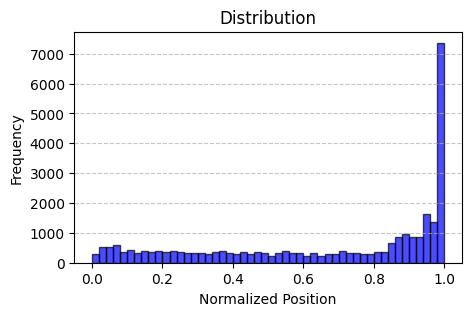

In [342]:
# plot the new normalized positions
plt.figure(figsize=(5, 3))
plt.hist(data['pos_normalized'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution')
plt.xlabel('Normalized Position')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Sort the data

In [343]:
# Convert the date column to datetime format if not already
data['date'] = pd.to_datetime(data['date'])

# Sort by player ID and date
data.sort_values(by=['player id', 'date'], inplace=True)

# 3. Feature Engineering

In [344]:
# drop rows where n_rounds or strokes are NaN or 0
data = data.dropna(subset=['n_rounds', 'strokes'])  
data = data[(data['n_rounds'] > 0) & (data['strokes'] > 0)]

# Create avg_strokes_per_round
data['avg_strokes_per_round'] = data['strokes'] / data['n_rounds']

# Drop redundant columns
data = data.drop(columns=['strokes', 'n_rounds'])

In [345]:
rolling_strokes_gained = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
for metric in rolling_strokes_gained:
    data[f'{metric}_rolling_mean'] = data.groupby('player id')[metric].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

In [346]:
# lets drop the data that we do not need for training
features_to_drop = ['tournament id','hole_par','player','tournament name','course','season','purse','no_cut', 'field_size']
data = data.drop(columns=features_to_drop, errors='ignore')

In [347]:
# lets normalize our data the best we can 
scaler = StandardScaler()
scaled_columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
       'pos_normalized', 'sg_putt_rolling_mean',
       'sg_arg_rolling_mean', 'sg_app_rolling_mean', 'sg_ott_rolling_mean',
       'sg_t2g_rolling_mean', 'sg_total_rolling_mean']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

In [348]:
# summary of our work
print("Summary of Preprocessed Data:")
print(f"Shape: {data.shape}")
print("Columns:")
print(data.columns)
print("Sample Rows:")
print(data.head())
print("Missing Values Per Column:")
print(data.isnull().sum())

Summary of Preprocessed Data:
Shape: (29176, 18)
Columns:
Index(['player id', 'made_cut', 'pos', 'date', 'sg_putt', 'sg_arg', 'sg_app',
       'sg_ott', 'sg_t2g', 'sg_total', 'pos_normalized',
       'avg_strokes_per_round', 'sg_putt_rolling_mean', 'sg_arg_rolling_mean',
       'sg_app_rolling_mean', 'sg_ott_rolling_mean', 'sg_t2g_rolling_mean',
       'sg_total_rolling_mean'],
      dtype='object')
Sample Rows:
       player id  made_cut   pos       date   sg_putt    sg_arg    sg_app  \
36718          5         0  69.0 2014-10-19 -1.169243  1.568545 -0.239523   
36165          5         0  71.0 2015-01-18 -2.116144 -0.603885  0.376663   
35940          5         0  68.0 2015-02-01  0.626297  0.234838  0.260570   
35830          5         0  63.0 2015-02-08 -0.731524 -1.222616  1.492943   
35474          5         1  51.0 2015-03-02 -1.124577  0.138591  1.439362   

         sg_ott    sg_t2g  sg_total  pos_normalized  avg_strokes_per_round  \
36718 -0.871339  0.102622 -0.581844        

# 4. Split the data

In [349]:
# lets just make srue we have the correct ordering
data.sort_values(by=['player id', 'date'], inplace=True)

In [350]:
latest_tournament_mask = data.groupby('player id')['date'].transform('max') == data['date']
train_data = data[~latest_tournament_mask]
test_data = data[latest_tournament_mask]

# Model Development
After doing a bit of research on models that are best for time series of data RNN or LSTMs seem best
BUT.... they require sequences of data. So grouping of tournaments are required. This creates a problem since players have different lengths of sequences.

In [383]:
def create_sequences(data, sequence_length, features, target):
    sequences = []
    targets = []
    for player_id, group in data.groupby('player id'):
        group = group.sort_values(by='date')
        player_data = group[features].values
        player_target = group[target].values
        for i in range(len(player_data) - sequence_length + 1):
            sequences.append(player_data[i:i+sequence_length])
            targets.append(player_target[i+sequence_length-1])
    return np.array(sequences), np.array(targets)

# Features and target
features = ['made_cut', 'sg_putt', 'sg_arg', 'sg_app','sg_ott', 
            'sg_t2g', 'sg_total', 'pos_normalized', 'avg_strokes_per_round', 
            'sg_putt_rolling_mean', 'sg_arg_rolling_mean','sg_app_rolling_mean', 
            'sg_ott_rolling_mean', 'sg_t2g_rolling_mean','sg_total_rolling_mean']

target = 'pos'

# sequences
sequence_length = 5
X, y = create_sequences(data, sequence_length, features, target)

In [384]:
# now we need to pad the shorter histories using keras
X_padded = pad_sequences(X, maxlen=sequence_length, padding='pre', dtype='float32', value=0.0)

In [385]:
# as a NON ml engineer I am starting to leave my comfort zone
# tensorflow has a decent guide here - https://www.tensorflow.org/guide/keras/understanding_masking_and_padding
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input

def weighted_mse(y_true, y_pred):
    weights = tf.where(y_true <= 10, 2.0, 1.0)  # Double the weight for good golfers
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

In [386]:
# Build the model
model = Sequential([
    Input(shape=(sequence_length, len(features))),
    Masking(mask_value=0.0),
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss=weighted_mse,
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=32,  
    verbose=1
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1987.4077 - mae: 38.2875 - val_loss: 753.5986 - val_mae: 23.2947
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 588.1478 - mae: 20.1116 - val_loss: 205.8762 - val_mae: 10.1366
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 190.4912 - mae: 9.2018 - val_loss: 136.1811 - val_mae: 6.2616
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 161.0399 - mae: 6.8740 - val_loss: 125.6636 - val_mae: 5.3080
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 150.0582 - mae: 6.3813 - val_loss: 122.5065 - val_mae: 5.0121
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 142.9676 - mae: 6.1133 - val_loss: 120.8896 - val_mae: 5.1028
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 120.8201 - mae: 5.8383 - val_loss: 123.5986 - val_mae: 5.4583
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 138.9135 - mae: 5.9935 - val_loss: 124.5411 - val_mae: 5.2707
Epoch 9/50
675/675 

In [387]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [388]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test)

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 104.3409 - mae: 5.1469
Test Loss: 107.09783935546875, Test MAE: 5.11920690536499
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [389]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
results['Error'] = results['Actual'] - results['Predicted']
# Create bins and group the data
binned_results = results.groupby(
    pd.cut(results['Actual'], bins=[0, 10, 50, 100]), observed=False
).mean()

print(binned_results)

              Actual  Predicted     Error
Actual                                   
(0, 10]     5.111876  11.288827 -6.176951
(10, 50]   29.540210  29.590929 -0.050720
(50, 100]  68.382001  64.191223  4.190775


#### It looks like our model is pretty good at predicting the middle of the pack but not the best at picking the top 10